<font size="5">**Fraud Detection - Case study**</font>

Binary classification - fraud detection

Please note: all paths in this notebook are relative. The notebook is supposed not to be moved from this location in the app package.

# The data

In [103]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('../FraudDetectionModel/data/dataset.csv', sep=';', index_col='uuid')
data.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,...,1,1,1,1,0,0,0,178839,9.653333,1.0
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


The rows with missing default will separated from the rest of the data and will only be used for prediction. In the following we refer to the 89976 rows with default value.

In [ ]:
missing_default = data[data['default'].isnull()]
data.drop(index=missing_default.index, inplace=True)
missing_default.to_csv('../FraudDetectionModel/data/data_to_predict.csv')
data.to_csv('../FraudDetectionModel/data/data_with_default.csv')

In [ ]:
data = pd.read_csv('../FraudDetectionModel/data/data_with_default.csv', index_col='uuid')

## Duplicate rows

There is one duplicate row. This will be dropped to avoid data leakage.

In [6]:
data.drop_duplicates(inplace=True)
data.shape

(89975, 42)

## Default classes

The classes are unbalanced (~98.6% default 0), but this is representative of reality, therefore the inequality will be kept.

In [7]:
X = data.drop(columns='default')
y = data['default']

In [8]:
y.value_counts()

0.0    88687
1.0     1288
Name: default, dtype: int64

In [9]:
y.value_counts()/y.count()

0.0    0.985685
1.0    0.014315
Name: default, dtype: float64

## Holdout

Before proceding, we will separate our data in train and test set. This will be done via Holdout method, ratio 70/30.
The test set will be kept unseen for the model in every step of the training (included EDA!) and fine tuning. This will be used only to estimate its performance as a final step before using the model to predict new data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## EDA

Exploratory data analysis. We want to:
- detect missing values and decide how to deal with them
- detect outliers and decide wether they are genuine data or mistakes
- find possible correlations between feature and default (-> relevant feature) and among features (-> feature selection)

EDA will be conducted on the training set only, as involving the testing set would introduce a bias in out final evaluation.

### Missing values

In [11]:
# rows
X_train.dropna().shape[0]

6382

We cannot just drop the rows with missing values, we would otherwise reduce out set size by 90%! Moreover, we can expect new incoming data to also have missing values. We want therefore to analyze the problem from the point of view of features.

In [12]:
# columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62982 entries, ebec3a0d-0b6c-4a05-8b12-dd3014e077d2 to d2debcc3-5f1d-4ca0-a10f-edd80d3f7c43
Data columns (total 41 columns):
account_amount_added_12_24m            62982 non-null int64
account_days_in_dc_12_24m              55510 non-null float64
account_days_in_rem_12_24m             55510 non-null float64
account_days_in_term_12_24m            55510 non-null float64
account_incoming_debt_vs_paid_0_24m    25658 non-null float64
account_status                         28774 non-null float64
account_worst_status_0_3m              28774 non-null float64
account_worst_status_12_24m            20943 non-null float64
account_worst_status_3_6m              26631 non-null float64
account_worst_status_6_12m             25026 non-null float64
age                                    62982 non-null int64
avg_payment_span_0_12m                 47969 non-null float64
avg_payment_span_0_3m                  31809 non-null float64
merchant_category           

The total number of rows is 62982 and we have 41 columns. Of those, 26 have no missing data. Of the other 15, the ratio of missing data is between 11.9% and 69.6%.

In [13]:
print((62982-19158)/62982, (62982-55510)/62982)

0.6958178527198247 0.11863707090914864


An option would be to drop all the columns with missing data. We would still keep 26 features for our model. Another option is to set a threshold for the ratio of missing data allowed and use an imputer for the missing values that we are keeping. An interesting observation is that all columns with missing values are numerical features. In the case of categorical features we could have just added a new category 'unknown'.   

In order to decide what to do with the columns with missing data, we want to analyse how important these features are (correlation) and how hard it would be to fill in the blanks. 

In [14]:
data_train = pd.concat([y_train, X_train], axis=1)
data_train.corr()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
default,1.000000,0.007170,0.073867,0.086773,0.092133,0.000545,0.121818,0.159755,0.170634,0.163735,...,-0.021185,-0.032111,0.000024,0.020097,0.050648,0.003901,0.006873,-0.035030,-0.013982,0.065528
account_amount_added_12_24m,0.007170,1.000000,0.005219,0.167788,0.037082,-0.023921,0.009463,0.084139,0.086217,0.066406,...,0.173558,0.164099,0.189678,0.218427,-0.001338,0.664036,0.707682,0.131370,-0.002104,0.031232
account_days_in_dc_12_24m,0.073867,0.005219,1.000000,0.072228,0.326017,-0.002399,0.026540,0.054130,0.294253,0.063191,...,0.005819,0.003192,0.009179,0.029182,-0.000508,0.010326,0.037751,-0.007735,-0.004687,0.029653
account_days_in_rem_12_24m,0.086773,0.167788,0.072228,1.000000,0.353421,-0.012157,0.161966,0.249425,0.603945,0.273702,...,0.124923,0.081220,0.151551,0.213149,0.015172,0.142110,0.179873,-0.009358,0.000276,0.103542
account_days_in_term_12_24m,0.092133,0.037082,0.326017,0.353421,1.000000,-0.006126,0.067689,0.129247,0.550169,0.151055,...,0.053107,0.029637,0.062849,0.105694,0.003834,0.032966,0.051262,-0.011884,-0.003352,0.076906
account_incoming_debt_vs_paid_0_24m,0.000545,-0.023921,-0.002399,-0.012157,-0.006126,1.000000,0.002946,-0.009050,-0.019777,-0.012103,...,-0.006564,-0.002460,-0.011141,-0.018167,0.000419,-0.033312,-0.029040,0.006024,-0.005609,-0.010310
account_status,0.121818,0.009463,0.026540,0.161966,0.067689,0.002946,1.000000,0.433453,0.144592,0.241117,...,0.001903,-0.001258,0.048499,0.067251,0.085755,-0.032742,-0.002938,-0.030435,0.009229,0.094755
account_worst_status_0_3m,0.159755,0.084139,0.054130,0.249425,0.129247,-0.009050,0.433453,1.000000,0.297005,0.510618,...,0.061760,0.034853,0.124675,0.173325,0.044797,0.065672,0.047912,-0.070917,0.000627,0.124501
account_worst_status_12_24m,0.170634,0.086217,0.294253,0.603945,0.550169,-0.019777,0.144592,0.297005,1.000000,0.310423,...,0.083032,0.038920,0.144543,0.241614,0.015213,0.053232,0.118254,-0.115222,-0.011142,0.154214
account_worst_status_3_6m,0.163735,0.066406,0.063191,0.273702,0.151055,-0.012103,0.241117,0.510618,0.310423,1.000000,...,0.064978,0.016972,0.115513,0.177477,0.041254,0.056963,0.025028,-0.093231,-0.001879,0.097633


The most relevant features seem to be the ones coding for the account status. Unfortunately, these are also the features with the most data missing. In order to decide how to proceed, we first want to have a closer look at the values in these columns.

In [15]:
cols = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',
       'account_worst_status_3_6m', 'account_worst_status_6_12m', 'avg_payment_span_0_12m',
       'num_active_div_by_paid_inv_0_12m', 'num_arch_dc_0_12m', 'num_arch_dc_0_12m']

for col in cols:
    ratio = X_train[col].isnull().sum()/62982
    print(col, ratio, X_train[col].nunique())

account_status 0.5431393096440252 4
account_worst_status_0_3m 0.5431393096440252 4
account_worst_status_12_24m 0.6674764218348099 4
account_worst_status_3_6m 0.5771649042583595 4
account_worst_status_6_12m 0.6026483757263981 4
avg_payment_span_0_12m 0.2383696929281382 6337
num_active_div_by_paid_inv_0_12m 0.22960528404941094 705
num_arch_dc_0_12m 0.0 13
num_arch_dc_0_12m 0.0 13


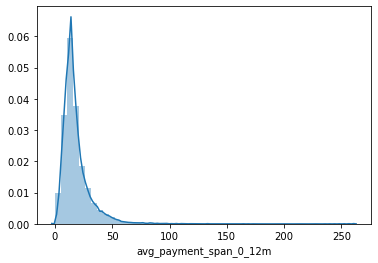

In [16]:
sns.distplot(X_train['avg_payment_span_0_12m'])

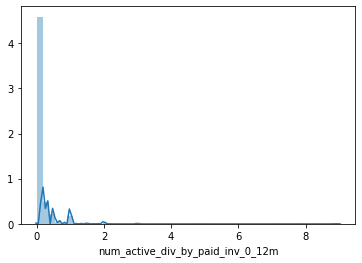

In [17]:
sns.distplot(X_train['num_active_div_by_paid_inv_0_12m'])

In [18]:
pd.set_option('display.max_columns', 40)
X_train.describe()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
count,6.298200e+04,55510.000000,55510.000000,55510.000000,25658.000000,28774.000000,28774.000000,20943.000000,26631.000000,25026.000000,62982.000000,47969.000000,31809.000000,62982.000000,62982.000000,48521.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,51530.000000,51530.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,6.298200e+04,62982.000000,19158.000000
mean,1.236429e+04,0.225059,5.025365,0.290668,1.236958,1.041913,1.173108,1.339350,1.185723,1.256893,36.013083,18.046069,14.951138,9236.769855,11246.642914,0.115218,0.598298,0.062843,0.060779,7.243832,6.358849,0.469325,0.000116,0.000175,2.153330,0.923835,0.826617,0.742101,0.800768,1.053476,1.226462,4.398352,10942.638278,6630.385221,3.927950e+04,15.343093,1.123865
std,3.557114e+04,5.748081,22.805093,2.962882,18.362497,0.202120,0.419801,0.577126,0.442377,0.508054,13.016339,12.986770,10.270142,13637.176972,15254.008744,0.296578,1.548684,0.370325,0.373401,16.023480,15.507885,1.370552,0.010790,0.014610,6.306666,0.572739,0.624475,0.634380,0.721440,0.788103,0.836511,191.166389,26856.353900,19449.681756,9.237342e+04,5.037174,0.346126
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278,1.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,10.800000,8.333333,2000.000000,3310.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.595000e+03,11.637222,1.000000
50%,0.000000e+00,0.000000,0.000000,0.000000,0.155369,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,14.894737,13.000000,6070.000000,7595.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.595050e+04,15.830556,1.000000
75%,5.025750e+03,0.000000,0.000000,0.000000,0.671135,1.000000,1.000000,2.000000,1.000000,1.000000,45.000000,21.200000,18.230769,11390.000000,13826.250000,0.100000,1.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9097.500000,100.000000,4.385900e+04,19.553056,1.000000
max,1.128654e+06,350.000000,365.000000,97.000000,1443.480000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,260.000000,84.000000,279000.000000,279000.000000,9.000000,37.000000,13.000000,13.000000,261.000000,313.000000,42.000000,1.000000,2.000000,160.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722,3.000000


For the account_status columns there are only 4 unique values, meaning that tho represented as numbers, these states are categories. We will therefore introduce a new category representing 'unknown status' and the encode the columns.   
For the columns num_active_div_by_paid_inv_0_12m and avg_payment_span_0_12m, we will substitute the missing values with the median. Reason for this choise is that there are many outliers and we don't want our new values to be influenced by that.  
It could be a good idea to add a boolean column to register if the value was missing at the beginning. We will not do it in this analysis.

In [19]:
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

In [20]:
cols = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',
       'account_worst_status_3_6m', 'account_worst_status_6_12m']

zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
for col in cols:
    zero_imputer.fit(X_train_clean[[col]])
    X_train_clean[col] = zero_imputer.transform(X_train_clean[[col]])
    X_test_clean[col] = zero_imputer.transform(X_test_clean[[col]])

In [21]:
cols = ['avg_payment_span_0_12m', 'num_active_div_by_paid_inv_0_12m']

median_imputer = SimpleImputer(strategy='median')
for col in cols:
    median_imputer.fit(X_train_clean[[col]])
    X_train_clean[col] = median_imputer.transform(X_train_clean[[col]])
    X_test_clean[col] = median_imputer.transform(X_test_clean[[col]])

In [22]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62982 entries, ebec3a0d-0b6c-4a05-8b12-dd3014e077d2 to d2debcc3-5f1d-4ca0-a10f-edd80d3f7c43
Data columns (total 41 columns):
account_amount_added_12_24m            62982 non-null int64
account_days_in_dc_12_24m              55510 non-null float64
account_days_in_rem_12_24m             55510 non-null float64
account_days_in_term_12_24m            55510 non-null float64
account_incoming_debt_vs_paid_0_24m    25658 non-null float64
account_status                         62982 non-null float64
account_worst_status_0_3m              62982 non-null float64
account_worst_status_12_24m            62982 non-null float64
account_worst_status_3_6m              62982 non-null float64
account_worst_status_6_12m             62982 non-null float64
age                                    62982 non-null int64
avg_payment_span_0_12m                 62982 non-null float64
avg_payment_span_0_3m                  31809 non-null float64
merchant_category           

There still are a few problematic columns. Of those, the account_days ones only have ~12% of data missing and a correlation of approximately 0.08. Tho it not being high, it is among the highest we have for thesee features. We will therefore keep these columns. However, considering the distribution of values (outliers!), the value will be set to zero.   
Other columns with very low correlation will be deleted.

In [23]:
missing_data_ratio = []
for col in X_train.columns:
    ratio = X_train[col].isnull().sum()/62982
    if ratio <= 0.3 and ratio != 0:
        missing_data_ratio.append((col, ratio))
missing_data_ratio

[('account_days_in_dc_12_24m', 0.11863707090914864),
 ('account_days_in_rem_12_24m', 0.11863707090914864),
 ('account_days_in_term_12_24m', 0.11863707090914864),
 ('avg_payment_span_0_12m', 0.2383696929281382),
 ('num_active_div_by_paid_inv_0_12m', 0.22960528404941094),
 ('num_arch_written_off_0_12m', 0.18182972912895748),
 ('num_arch_written_off_12_24m', 0.18182972912895748)]

In [24]:
cols = ['avg_payment_span_0_3m', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 
 'account_days_in_term_12_24m', 'avg_payment_span_0_12m', 'num_active_div_by_paid_inv_0_12m',
 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m']

X_train_clean[cols].describe()

,avg_payment_span_0_3m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,avg_payment_span_0_12m,num_active_div_by_paid_inv_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m
count,31809.000000,55510.000000,55510.000000,55510.000000,62982.000000,62982.000000,51530.000000,51530.000000
mean,14.951138,0.225059,5.025365,0.290668,17.294887,0.088763,0.000116,0.000175
std,10.270142,5.748081,22.805093,2.962882,11.412975,0.264784,0.010790,0.014610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.333333,0.000000,0.000000,0.000000,12.200000,0.000000,0.000000,0.000000
50%,13.000000,0.000000,0.000000,0.000000,14.894737,0.000000,0.000000,0.000000
75%,18.230769,0.000000,0.000000,0.000000,18.665789,0.050000,0.000000,0.000000
max,84.000000,350.000000,365.000000,97.000000,260.000000,9.000000,1.000000,2.000000


In [25]:
#simple imputer!

In [26]:
cols = ['account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m']

for col in cols:
    zero_imputer.fit(X_train_clean[[col]])
    X_train_clean[col] = zero_imputer.transform(X_train_clean[[col]])
    X_test_clean[col] = zero_imputer.transform(X_test_clean[[col]])

In [27]:
X_train_clean.dropna(axis=1, inplace=True)
X_train_clean.columns

Index(['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'age', 'avg_payment_span_0_12m',
       'merchant_category', 'merchant_group', 'has_paid', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m', 'num_unpaid_bills',
       'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_12_months', 'status_max_archived_0_24_months',
       'recovery_debt', 'sum_capital_paid_account_0_12m',
       'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 

In [28]:
X_train_clean.drop(columns=['status_2nd_last_archived_0_24m',
    'status_max_archived_0_12_months', 'sum_capital_paid_account_0_12m',
 'sum_capital_paid_account_12_24m', 'num_arch_rem_0_12m'], inplace=True)

X_train_clean.head()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_24_months,recovery_debt,sum_paid_inv_0_12m,time_hours
uuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ebec3a0d-0b6c-4a05-8b12-dd3014e077d2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,14.894737,Concept stores & Miscellaneous,"Leisure, Sport & Hobby",False,0.0,0.0,no_match,0.0,0,0,0,0,0,0,0,0,0,0,0,0,21.815556
f7995fcf-e171-4793-b8ab-b815b159fb44,14586,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,35,20.000000,General Shoes & Clothing,Clothing & Shoes,True,14678.0,14678.0,F+L,0.0,0,0,0,5,10,0,1,2,2,2,0,55209,13.193056
67362245-0b45-4377-9df2-8e05ce9f042b,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,14.894737,Diversified entertainment,Entertainment,False,0.0,0.0,F+L,0.0,0,0,0,0,0,0,0,0,0,0,0,0,11.449444
249d6fcf-c9ab-4c01-bb34-94fadda81a83,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,14.000000,Electronic equipment & Related accessories,Electronics,True,4290.0,4290.0,F+L,1.0,1,0,0,1,1,1,1,0,0,1,0,4290,23.593333
221d6a79-1662-42de-829a-f4ebbeadcfb8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,14.894737,Dietary supplements,Health & Beauty,False,0.0,0.0,L1+F,0.0,0,0,0,0,0,0,0,0,0,0,0,0,15.500278


In [29]:
X_train_clean.shape

(62982, 31)

In [30]:
X_test_clean = X_test_clean[X_train_clean.columns]
X_test_clean.shape

(26993, 31)

In [31]:
X_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26993 entries, 20daeb41-1bf5-4c0d-922f-4a09745721b1 to 9b09f970-e358-4486-a363-870a7a72ee5b
Data columns (total 31 columns):
account_amount_added_12_24m         26993 non-null int64
account_days_in_dc_12_24m           26993 non-null float64
account_days_in_rem_12_24m          26993 non-null float64
account_days_in_term_12_24m         26993 non-null float64
account_status                      26993 non-null float64
account_worst_status_0_3m           26993 non-null float64
account_worst_status_12_24m         26993 non-null float64
account_worst_status_3_6m           26993 non-null float64
account_worst_status_6_12m          26993 non-null float64
age                                 26993 non-null int64
avg_payment_span_0_12m              26993 non-null float64
merchant_category                   26993 non-null object
merchant_group                      26993 non-null object
has_paid                            26993 non-null bool
max_paid_inv_

**In conclusion**:
- 31 remaining columns
- simple imputer with value 0 for 'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'account_worst_status_3_6m', 'account_worst_status_6_12m', 'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m', 'account_days_in_term_12_24m'
- simple imputer with median for 'avg_payment_span_0_12m', 'num_active_div_by_paid_inv_0_12m'

### Outliers

In [32]:
X_train.describe()

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
count,6.298200e+04,55510.000000,55510.000000,55510.000000,25658.000000,28774.000000,28774.000000,20943.000000,26631.000000,25026.000000,62982.000000,47969.000000,31809.000000,62982.000000,62982.000000,48521.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,51530.000000,51530.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,62982.000000,6.298200e+04,62982.000000,19158.000000
mean,1.236429e+04,0.225059,5.025365,0.290668,1.236958,1.041913,1.173108,1.339350,1.185723,1.256893,36.013083,18.046069,14.951138,9236.769855,11246.642914,0.115218,0.598298,0.062843,0.060779,7.243832,6.358849,0.469325,0.000116,0.000175,2.153330,0.923835,0.826617,0.742101,0.800768,1.053476,1.226462,4.398352,10942.638278,6630.385221,3.927950e+04,15.343093,1.123865
std,3.557114e+04,5.748081,22.805093,2.962882,18.362497,0.202120,0.419801,0.577126,0.442377,0.508054,13.016339,12.986770,10.270142,13637.176972,15254.008744,0.296578,1.548684,0.370325,0.373401,16.023480,15.507885,1.370552,0.010790,0.014610,6.306666,0.572739,0.624475,0.634380,0.721440,0.788103,0.836511,191.166389,26856.353900,19449.681756,9.237342e+04,5.037174,0.346126
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278,1.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,10.800000,8.333333,2000.000000,3310.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.595000e+03,11.637222,1.000000
50%,0.000000e+00,0.000000,0.000000,0.000000,0.155369,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,14.894737,13.000000,6070.000000,7595.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.595050e+04,15.830556,1.000000
75%,5.025750e+03,0.000000,0.000000,0.000000,0.671135,1.000000,1.000000,2.000000,1.000000,1.000000,45.000000,21.200000,18.230769,11390.000000,13826.250000,0.100000,1.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9097.500000,100.000000,4.385900e+04,19.553056,1.000000
max,1.128654e+06,350.000000,365.000000,97.000000,1443.480000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,260.000000,84.000000,279000.000000,279000.000000,9.000000,37.000000,13.000000,13.000000,261.000000,313.000000,42.000000,1.000000,2.000000,160.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722,3.000000


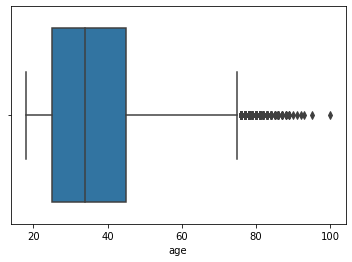

In [33]:
sns.boxplot(X_train['age'])

In the dataset there is a great number of outliers. However none of those can be immediately recognized as an error (data like time is always between 0 and 24, counts always non negative...). The only excetion is in the column 'age', where there in an entry with value 100. Again, it is not necessary a mistake, but looks unlikely.

Not having a solid reason to consider outliers not valuable information, we will keep them. Moreover, in our study outliers could be relevant to detect default cases.

## Feature engineering

In this specific case, no new feature will be introduced. Main reasons for this are:
- there are already very specific features
- I would need more field knowledge/context to come up with useful features   
   
Anyway an idea for new features would be to map the account status and track changings over time

## Scaling and encoding

In [34]:
X_train_clean.nunique()

account_amount_added_12_24m         15922
account_days_in_dc_12_24m             104
account_days_in_rem_12_24m            264
account_days_in_term_12_24m            58
account_status                          5
account_worst_status_0_3m               5
account_worst_status_12_24m             5
account_worst_status_3_6m               5
account_worst_status_6_12m              5
age                                    78
avg_payment_span_0_12m               6337
merchant_category                      57
merchant_group                         12
has_paid                                2
max_paid_inv_0_12m                  10303
max_paid_inv_0_24m                  10744
name_in_email                           8
num_active_div_by_paid_inv_0_12m      705
num_active_inv                         35
num_arch_dc_0_12m                      13
num_arch_dc_12_24m                     13
num_arch_ok_0_12m                     194
num_arch_ok_12_24m                    191
num_unpaid_bills                  

In columns such as 'account_status' and similar, the feature is an ordinal category. The fact of having a numerical encoding system forces an order relationship that might not exist and could cause problems to the algorithm. For this reason we will consider these columns as categorical and use OneHotEncoding.

In [35]:
CAT_COLS = ['account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'merchant_category', 'merchant_group',
        'name_in_email', 'status_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_24_months']

NUM_COLS = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
        'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'age',
        'avg_payment_span_0_12m', 'has_paid', 'max_paid_inv_0_12m',
        'max_paid_inv_0_24m', 'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_unpaid_bills', 'recovery_debt',
       'sum_paid_inv_0_12m', 'time_hours']

COLS = CAT_COLS + NUM_COLS   

In [38]:
X_train_encoded = X_train_clean.copy()
X_test_encoded = X_test_clean.copy()

In [39]:
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), CAT_COLS),
                        ('r_scaler', RobustScaler(), NUM_COLS)])

ct.fit(X_train_encoded)
X_train_encoded = ct.transform(X_train_clean)
X_test_encoded = ct.transform(X_test_clean)

In [58]:
#pd.DataFrame(X_train_encoded).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,-0.40,0.000000,-1.0,-0.646432,-0.722216,0.0,0.0,0.0,0.0,-0.285714,-0.333333,0.0,0.0,-0.386548,0.756080
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.902253,0.0,0.0,0.0,0.05,0.789581,0.0,0.916720,0.673529,0.0,0.0,0.0,0.0,0.428571,1.333333,0.0,0.0,0.951398,-0.333193
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,-0.70,0.000000,-1.0,-0.646432,-0.722216,0.0,0.0,0.0,0.0,-0.285714,-0.333333,0.0,0.0,-0.386548,-0.553462
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,-0.30,-0.138380,0.0,-0.189563,-0.314276,20.0,1.0,0.0,0.0,-0.142857,-0.166667,0.5,0.0,-0.282583,0.980665
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,1.05,0.000000,-1.0,-0.646432,-0.722216,0.0,0.0,0.0,0.0,-0.285714,-0.333333,0.0,0.0,-0.386548,-0.041724


## PCA

We currently have 140 features. This can lead to a very heavy and not optimal model. We might consider therefore to reduce dimensionality. (To do so, we first perform PCA to have an idea about the range within we can find the optimal number of features. When training the model, the number will be considered as an hyperparameter within this range an be optimized.)   
However, checking the fetures correlation:

In [72]:
pd.DataFrame(X_train_encoded).corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139
0,1.000000,-0.962257,-0.151441,-0.008690,-0.006144,1.000000,-0.861390,-0.292454,-0.072600,-0.035315,0.769586,-0.604486,-0.331664,-0.109863,-0.056556,0.933253,-0.804071,-0.285269,-0.077795,-0.041475,...,-0.009844,-0.378999,-0.040075,-0.224923,-0.100365,0.132875,-0.189476,-0.370436,-0.123657,-0.144817,-0.123033,-0.167092,-0.118326,-0.121823,-0.117563,-0.119970,-0.301242,-0.012712,-0.142603,-0.002866
1,-0.962257,1.000000,-0.122576,-0.007033,-0.004973,-0.962257,0.895177,0.156711,0.053723,0.034722,-0.737207,0.599594,0.294327,0.088184,0.044546,-0.895293,0.806264,0.212160,0.052445,0.038889,...,0.006162,0.362201,0.031240,0.173150,0.078314,-0.120300,0.160671,0.356130,0.125764,0.146064,0.108644,0.157867,0.092213,0.104560,0.121494,0.123751,0.273270,0.003678,0.143476,0.000976
2,-0.151441,-0.122576,1.000000,-0.001107,-0.000783,-0.151441,-0.109727,0.498735,0.062818,-0.004499,-0.129014,0.026862,0.141056,0.078290,0.044601,-0.151186,0.003929,0.269630,0.093499,0.003920,...,0.005745,0.066689,0.032787,0.191159,0.081038,-0.047701,0.107001,0.057271,-0.005714,-0.002235,0.054084,0.036102,0.096625,0.064455,-0.012542,-0.011997,0.105853,0.010251,-0.001072,0.007111
3,-0.008690,-0.007033,-0.001107,1.000000,-0.000045,-0.008690,-0.006296,-0.002138,0.119691,-0.000258,-0.002833,0.000280,-0.002424,0.019171,-0.000413,-0.009311,0.002465,0.014188,-0.000569,-0.000303,...,-0.000119,0.001114,-0.000293,0.008007,0.005709,0.000910,0.010266,0.003342,0.000197,-0.000358,0.003432,0.000781,0.004028,0.004039,0.001122,0.001743,0.005177,0.010249,0.001648,-0.002277
4,-0.006144,-0.004973,-0.000783,-0.000045,1.000000,-0.006144,-0.004452,-0.001511,-0.000375,0.173989,-0.002003,-0.003124,-0.001714,0.027680,-0.000292,-0.006584,-0.004156,-0.001474,-0.000402,0.148145,...,0.188922,0.000246,-0.000207,0.004743,0.009605,-0.002387,0.001803,0.002363,-0.003408,-0.003494,-0.001889,-0.002177,-0.000956,-0.000917,-0.002372,-0.002311,0.003437,0.537544,-0.002281,-0.001267
5,1.000000,-0.962257,-0.151441,-0.008690,-0.006144,1.000000,-0.861390,-0.292454,-0.072600,-0.035315,0.769586,-0.604486,-0.331664,-0.109863,-0.056556,0.933253,-0.804071,-0.285269,-0.077795,-0.041475,...,-0.009844,-0.378999,-0.040075,-0.224923,-0.100365,0.132875,-0.189476,-0.370436,-0.123657,-0.144817,-0.123033,-0.167092,-0.118326,-0.121823,-0.117563,-0.119970,-0.301242,-0.012712,-0.142603,-0.002866
6,-0.861390,0.895177,-0.109727,-0.006296,-0.004452,-0.861390,1.000000,-0.211900,-0.052603,-0.025587,-0.636099,0.582833,0.172834,0.033623,0.020227,-0.786489,0.804580,0.012452,0.010766,0.010338,...,0.005737,0.283267,0.013712,0.071547,0.030606,-0.097159,0.073103,0.317053,0.133064,0.150163,0.078691,0.144786,0.029528,0.051835,0.139781,0.135713,0.200021,0.000939,0.150484,0.000593
7,-0.292454,0.156711,0.498735,-0.002138,-0.001511,-0.292454,-0.211900,1.000000,-0.017859,-0.008687,-0.275092,0.070065,0.304943,0.123106,0.052325,-0.303480,0.048885,0.500698,0.055054,0.001491,...,0.004514,0.191631,0.038431,0.272811,0.108460,-0.068052,0.201693,0.111957,-0.010283,-0.002482,0.083950,0.047160,0.140739,0.116932,-0.032610,-0.021845,0.196964,0.009574,-0.006542,0.006797
8,-0.072600,0.053723,0.062818,0.119691,-0.000375,-0.072600,-0.052603,-0.017859,1.000000,-0.002157,-0.062308,0.004881,0.054588,0.098944,0.042846,-0.077793,-0.034562,0.154729,0.241551,-0.002533,...,-0.000993,0.035284,0.027820,0.103160,0.089052,-0.022406,0.092545,0.027925,-0.006650,-0.003902,0.026567,0.010002,0.105119,0.069342,-0.013375,-0.009402,0.052994,0.007149,-0.005103,-0.005282
9,-0.035315,0.034722,-0.004499,-0.000258,0.173989,-0.035315,-0.025587,-0.008687,-0.002157,1.000000,-0.030263,-0.007541,0.037737,0.031175,0.074210,-0.037840,-0.023885,0.015575,0.115209,0.476793,...,0.032436,0.022114,0.056642,0.066091,0.063846,-0.012851,0.068712,0.013584,-0.003535,-0.000771,0.007499,0.010619,0.074013,0.049926,-0.011886,-0.005053,-0.001021,0.092899,-0.005825,-0.006523


Most of the correlation is weak, as a consequence we cannot reduce the number of components too much.

In [43]:
pca = PCA()
pca.fit(X_train_encoded, y_train)
print(pca.explained_variance_ratio_)

[9.83292695e-01 1.24999725e-02 1.38479743e-03 8.16075123e-04
 7.44330285e-04 4.44024159e-04 1.72867463e-04 1.58902893e-04
 1.17174513e-04 8.34445950e-05 4.75384209e-05 3.66965272e-05
 2.47962612e-05 2.15079359e-05 1.65265041e-05 1.30815296e-05
 1.08991772e-05 1.02983473e-05 9.07610958e-06 7.88958828e-06
 6.08788622e-06 5.26194269e-06 5.19623445e-06 4.82895920e-06
 4.45452717e-06 4.33827990e-06 4.01291404e-06 3.83308502e-06
 3.53572172e-06 3.14868246e-06 3.00188586e-06 2.82095595e-06
 2.40516526e-06 2.37933720e-06 2.29376939e-06 2.21084221e-06
 2.05014022e-06 2.02386562e-06 1.86051843e-06 1.65759515e-06
 1.61802544e-06 1.54089648e-06 1.47534081e-06 1.20913859e-06
 1.06742114e-06 9.33245283e-07 9.02542184e-07 6.40173311e-07
 6.31351905e-07 6.10650909e-07 5.60713330e-07 5.20597888e-07
 5.12242942e-07 4.84790618e-07 4.61137318e-07 4.53287223e-07
 3.99689047e-07 3.84740560e-07 3.78704138e-07 3.52051145e-07
 3.48342165e-07 3.20254513e-07 2.89211962e-07 2.75014181e-07
 2.55233456e-07 2.445647

In [48]:
cumulative_importance = np.cumsum(pca.explained_variance_ratio_)
x = np.linspace(1,len(cumulative_importance)+1, len(cumulative_importance))

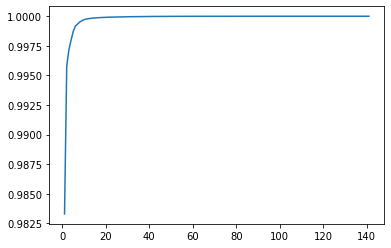

In [49]:
plt.plot(x, cumulative_importance)

(0.9925, 1.0)

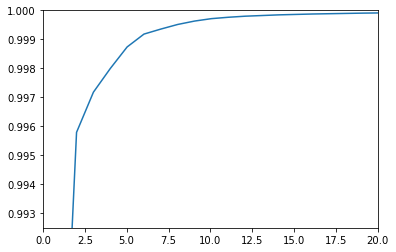

In [50]:
plt.plot(x, cumulative_importance)
plt.xlim(0,20)
plt.ylim(0.9925,1)

We will set the range between 5 and 20. All other components will be now dropped.

In [73]:
pca_100 = PCA(n_components=100)
pca_100.fit(X_train_encoded, y_train)

PCA(n_components=100)

In [74]:
X_train_reduced = pca_100.transform(X_train_encoded)
X_test_reduced = pca_100.transform(X_test_encoded)

# The model

## Metric

We cannot score our model on accuracy: even a dummy model always predicting default 0 would have a good accoracy, due to the imbalance between classes. Depending on what we want to enphasize, we can score on recall, precision or both (f1 score). Another option would be the ROC-AUC score, which we will not use due to class imbalance.    
Due to the nature of the problem, we will focus on the f1 score. The idea is that we want to minimize false positives and false negatives at the same time. In case one of the two is considered more important, it is possible to adjust the decision threshold.

## Baseline model

Imagine a simple model that always predicts default = 0. What are the scores of this model?

In [29]:
y.value_counts()

0.0    88688
1.0     1288
Name: default, dtype: int64

In [53]:
dummy_clf = DummyClassifier(strategy='most_frequent')
cv_results = cross_validate(dummy_clf, X_train_reduced, y_train, cv=5, return_estimator=True)
cv_results

{'fit_time': array([0.02300715, 0.0190022 , 0.01600051, 0.01700306, 0.02100182]),
 'score_time': array([0.00699377, 0.00599313, 0.00399899, 0.00599623, 0.00400138]),
 'estimator': (DummyClassifier(strategy='most_frequent'),
  DummyClassifier(strategy='most_frequent'),
  DummyClassifier(strategy='most_frequent'),
  DummyClassifier(strategy='most_frequent'),
  DummyClassifier(strategy='most_frequent')),
 'test_score': array([0.98579027, 0.98579027, 0.98578914, 0.98578914, 0.98578914])}

In [54]:
classifier = cv_results['estimator'][1]
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26600
         1.0       0.00      0.00      0.00       393

    accuracy                           0.99     26993
   macro avg       0.49      0.50      0.50     26993
weighted avg       0.97      0.99      0.98     26993



c:\users\jejba\.venvs\lewagon\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## My model

We first try different simple models. Once a promising one is found, we will proceed to hyperparameter tuning only on this model. (It is better to use a randomized search to select the model, but for computational reasons, since we are not too interested in the model performance, this will be left out in this study.)

In [58]:
from sklearn.svm import SVC

clf = SVC()
cv_r = cross_validate(clf, X_train_reduced, y_train, cv=5, scoring='f1')
cv_r

{'fit_time': array([5.46803999, 5.70499277, 5.33704376, 7.11600637, 5.85603571]),
 'score_time': array([0.82996154, 0.82803988, 0.82399988, 0.8960259 , 0.8360014 ]),
 'test_score': array([0., 0., 0., 0., 0.])}

In [ ]:
from sklearn.linear_model import SGDClassifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(3)
cv_r = cross_validate(clf, X_train_reduced, y_train, cv=5, scoring='f1')
cv_r

{'fit_time': array([0.86402655, 0.62400413, 0.65301132, 0.65801001, 0.66801167]),
 'score_time': array([7.17996693, 8.09600496, 7.78502727, 7.37398648, 7.54298925]),
 'test_score': array([0.32142857, 0.125     , 0.325     , 0.31914894, 0.2       ])}

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [70]:
cv_r = cross_validate(clf, X_train_encoded, y_train, cv=5, scoring='f1')
cv_r

{'fit_time': array([27.06113529, 27.36000228, 24.80199361, 23.29199147, 23.58200121]),
 'score_time': array([0.45099807, 0.43000031, 0.42100191, 0.38300157, 0.38906765]),
 'test_score': array([0.625     , 0.83333333, 0.69230769, 0.71428571, 0.66666667])}

In [ ]:
from sklearn.neural_network import MLPClassifier

In [62]:
!pip3 install xgboost

You should consider upgrading via the 'c:\users\jejba\.venvs\lewagon\scripts\python.exe -m pip install --upgrade pip' command.


In [78]:
from xgboost import XGBClassifier

clf = XGBClassifier()
cv_r = cross_validate(clf, X_train_reduced, y_train, cv=5, scoring='precision')
cv_r

{'fit_time': array([48.66399741, 45.55599952, 45.56399775, 45.395998  , 46.69499803]),
 'score_time': array([0.08400345, 0.08599973, 0.08600092, 0.09699988, 0.08500123]),
 'test_score': array([0.52      , 0.68181818, 0.64705882, 0.51851852, 0.5       ])}

In [80]:
clf = XGBClassifier()
cv_r = cross_validate(clf, X_train_reduced, y_train, cv=5, scoring='f1')
cv_r

{'fit_time': array([45.20002794, 45.85206366, 45.34899497, 49.38223672, 49.10555673]),
 'score_time': array([0.08700299, 0.0839994 , 0.08400178, 0.08800125, 0.08700085]),
 'test_score': array([0.12745098, 0.14925373, 0.20657277, 0.13592233, 0.10945274])}

ALthough the results not being really good, XGboost provides the best score. We will fine tune this model and proceed to validation.

## Fine tuning

In [86]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = KFold()

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5,
                         scoring = 'f1', 
                         verbose = 3, 
                         n_jobs = -1)

In [87]:
clf.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 33.5min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002104ED51748>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002104ED51C88>

In [89]:
clf.best_score_

0.16548948247931983

In [92]:
clf.best_estimator_.predict_proba(X_test_reduced)

array([[9.9996811e-01, 3.1883541e-05],
       [1.0000000e+00, 7.7547696e-10],
       [1.0000000e+00, 3.8957690e-09],
       ...,
       [9.9996215e-01, 3.7862195e-05],
       [1.0000000e+00, 2.7627627e-12],
       [9.9979651e-01, 2.0351000e-04]], dtype=float32)

In [153]:
import joblib

model_name = '../model/xgboost_best_model.joblib'
joblib.dump(clf.best_estimator_, model_name)

['../model/xgboost_best_model.joblib']

## Validation

In [95]:
y_pred = clf.best_estimator_.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     26600
         1.0       0.24      0.09      0.13       393

    accuracy                           0.98     26993
   macro avg       0.62      0.54      0.56     26993
weighted avg       0.98      0.98      0.98     26993



## Learning curves

In [100]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 100, 500, 2000, 5000]

train_sizes, train_scores, test_scores = learning_curve(
estimator = clf.best_estimator_,
X = X_train_reduced,
y = y_train, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

(0.0, 40.0)

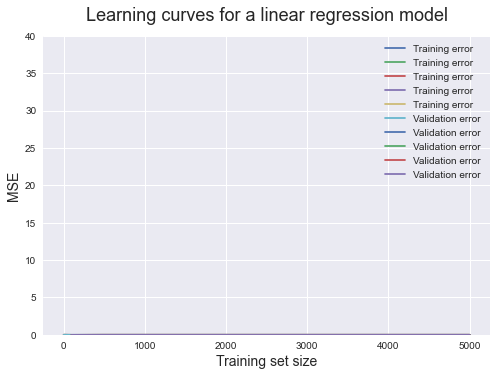

In [101]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores, label = 'Training error')
plt.plot(train_sizes, test_scores, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

# Pipeline

Pipeline:
- input raw data
- select columns
- imputers
- onehotencoder for categorical, scaler for numerical
- pca
- model.predict_proba
- output: uuid, predict proba [1]

In [102]:
X_train_clean.columns

Index(['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'age', 'avg_payment_span_0_12m',
       'merchant_category', 'merchant_group', 'has_paid', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_24_months', 'recovery_debt',
       'sum_paid_inv_0_12m', 'time_hours'],
      dtype='object')

In [104]:
COLS = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'age', 'avg_payment_span_0_12m',
       'merchant_category', 'merchant_group', 'has_paid', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_24_months', 'recovery_debt',
       'sum_paid_inv_0_12m', 'time_hours']

CAT_COLS = ['account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'merchant_category', 'merchant_group',
        'name_in_email', 'status_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_24_months']

NUM_COLS = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
        'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'age',
        'avg_payment_span_0_12m', 'has_paid', 'max_paid_inv_0_12m',
        'max_paid_inv_0_24m', 'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_unpaid_bills', 'recovery_debt',
       'sum_paid_inv_0_12m', 'time_hours']

model = clf.best_estimator_

In [115]:
numeric_transformer = Pipeline(steps=[
    ('m_imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())]) #NUM_COLS (median is zero for cols account_days)

categorical_transformer = Pipeline(steps=[
    ('z_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))]) #CAT_COLS

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_COLS),
        ('cat', categorical_transformer, CAT_COLS)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [116]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('m_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'age',
                                                   'avg_payment_span_0_12m',
                                                   'has_paid',
                                          

In [154]:
X_train.columns

Index(['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m',
       'account_incoming_debt_vs_paid_0_24m', 'account_status',
       'account_worst_status_0_3m', 'account_worst_status_12_24m',
       'account_worst_status_3_6m', 'account_worst_status_6_12m', 'age',
       'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'merchant_category',
       'merchant_group', 'has_paid', 'max_paid_inv_0_12m',
       'max_paid_inv_0_24m', 'name_in_email',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills', 'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       'status_max

In [149]:
C = X_train.columns

def predict_result(X, pipe):
    if 'uuid' in X.columns:
        result = X[['uuid']].copy()
    else:
        result = pd.DataFrame(index=X.index, columns=['pd'])
    X_ =pd.DataFrame(X, columns=C)
    result['pd'] = pipe.predict_proba(X_)[:, 1]
    print(result)
    return result

In [150]:
predict_result(X_test, pipe)

                                                pd
uuid                                              
20daeb41-1bf5-4c0d-922f-4a09745721b1  1.220237e-02
1eb41ded-2b7d-4b90-a44c-15cec7a5df76  4.411457e-07
8e3f9c46-9ff4-4519-aa8b-668ec73c9e9f  7.481984e-04
00356e40-17de-454c-80ad-e996d9b90744  2.093880e-09
251f3906-ac22-43c9-b87b-3b141398c5f1  1.368919e-09
096f3e3c-2dc8-4fff-b916-9004ab84b12a  2.077218e-08
16eaf371-fa27-43b0-be14-6b604a358ab8  7.181077e-07
bcfa471d-a175-4cdd-8586-0122a95e53ca  1.263852e-10
eefa1a4f-7344-44ac-b51b-5809b97f3dcf  9.642254e-08
d7ece46b-9065-4005-a4cb-862cd84d659a  2.432790e-10
01fc4b6c-5e82-45f0-a9aa-df671d14a815  4.057417e-12
ceb9ecde-5f4d-4068-a667-26475d441734  4.020761e-09
b577bede-2980-4d62-9a6f-72b85d85eb46  2.616054e-07
685d5d78-1115-400e-a7a2-681b465301d8  2.243729e-03
a3e04480-2b7f-4dbf-884a-c81e59090021  6.688744e-09
42bb4e9f-83e8-4b75-8b93-116ebd5fb6cd  1.481135e-07
88e53b88-a312-4f76-a10d-714d31406b4c  1.043542e-04
40f1f4d2-3ad6-4fb7-a540-c382749

,pd
uuid,
20daeb41-1bf5-4c0d-922f-4a09745721b1,1.220237e-02
1eb41ded-2b7d-4b90-a44c-15cec7a5df76,4.411457e-07
8e3f9c46-9ff4-4519-aa8b-668ec73c9e9f,7.481984e-04
00356e40-17de-454c-80ad-e996d9b90744,2.093880e-09
251f3906-ac22-43c9-b87b-3b141398c5f1,1.368919e-09
096f3e3c-2dc8-4fff-b916-9004ab84b12a,2.077218e-08
16eaf371-fa27-43b0-be14-6b604a358ab8,7.181077e-07
bcfa471d-a175-4cdd-8586-0122a95e53ca,1.263852e-10
eefa1a4f-7344-44ac-b51b-5809b97f3dcf,9.642254e-08


In [152]:
import joblib

joblib.dump(pipe, '../model/my_pipeline.joblib')

['../model/my_pipeline.joblib']

In [151]:
predict_result(missing_default, pipe)

                                                pd
uuid                                              
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7  1.781153e-08
f6f6d9f3-ef2b-4329-a388-c6a687f27e70  3.906438e-06
e9c39869-1bc5-4375-b627-a2df70b445ea  2.309321e-03
6beb88a3-9641-4381-beb6-c9a208664dd0  1.816762e-02
bb89b735-72fe-42a4-ba06-d63be0f4ca36  1.054551e-06
e4eede99-76a3-4437-a540-3059a1eff67c  1.436959e-09
a2af8d9e-9f81-4185-8fff-b2ec49d681a6  7.361703e-09
ec910486-1e66-402a-80f2-08c6f04a9a1b  8.904816e-03
08973cf0-646a-4fa7-9f1f-d03f76ffd59c  1.520295e-09
0591fb4e-5b48-4bac-bce7-f2d5d141e976  9.076759e-11
0d08fe69-ca57-433d-a6db-83970f6d11d8  2.511096e-07
53cfc224-c727-467c-b11b-585ce4137d83  7.823398e-12
7d7c6bed-ce10-45c3-8ef4-55e84ae7f9d9  7.365976e-08
d1087a43-7eb0-47ad-839c-14a0e8c5c0da  4.225152e-15
5c678d63-1da0-42e8-aed0-bafda88ffe98  1.114087e-09
8d1bd7fd-d065-425f-a35f-044a7af0217d  1.218567e-06
a0e7a004-a491-491b-a95c-d17de6b8b740  5.486745e-05
a111eeef-b3e1-4b2e-8d70-eacad33

,pd
uuid,
6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,1.781153e-08
f6f6d9f3-ef2b-4329-a388-c6a687f27e70,3.906438e-06
e9c39869-1bc5-4375-b627-a2df70b445ea,2.309321e-03
6beb88a3-9641-4381-beb6-c9a208664dd0,1.816762e-02
bb89b735-72fe-42a4-ba06-d63be0f4ca36,1.054551e-06
e4eede99-76a3-4437-a540-3059a1eff67c,1.436959e-09
a2af8d9e-9f81-4185-8fff-b2ec49d681a6,7.361703e-09
ec910486-1e66-402a-80f2-08c6f04a9a1b,8.904816e-03
08973cf0-646a-4fa7-9f1f-d03f76ffd59c,1.520295e-09
